###### 检查库包
### 若无 paddleseg 则pip install paddleseg

In [1]:
conda list

# packages in environment at /root/miniconda3:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main    https://repo.anaconda.com/pkgs/main
_openmp_mutex             4.5                       1_gnu    https://repo.anaconda.com/pkgs/main
absl-py                   1.0.0                    pypi_0    pypi
anyio                     3.5.0                    pypi_0    pypi
argon2-cffi               21.3.0                   pypi_0    pypi
argon2-cffi-bindings      21.2.0                   pypi_0    pypi
astor                     0.8.1                    pypi_0    pypi
asttokens                 2.0.5                    pypi_0    pypi
attrs                     21.4.0                   pypi_0    pypi
babel                     2.9.1                    pypi_0    pypi
backcall                  0.2.0                    pypi_0    pypi
bce-python-sdk            0.8.74                   pypi_0    pypi
bleach                    4.1.

# 生成数据列表

In [2]:
pwd

'/root/PaddleSeg'

In [3]:
# 训练的时候保证训练集、验证集不变

import random
import os.path as osp
from glob import glob

# 随机数生成器种子
RNG_SEED = 41
# 调节此参数控制训练集数据的占比
TRAIN_RATIO = 0.95
# 数据集路径  'PaddleSeg/datasets/'
DATA_DIR = 'datasets/'

def write_rel_paths(phase, names, out_dir, prefix=''):
    """将文件相对路径存储在txt格式文件中"""
    with open(osp.join(out_dir, phase+'.txt'), 'w') as f:
        for name in names:
            f.write(
                ' '.join([
                    osp.join(prefix, 'A', name),
                    osp.join(prefix, 'B', name),
                    osp.join(prefix, 'label', name)
                ])
            )
            f.write('\n')

random.seed(RNG_SEED)

# 随机划分训练集/验证集
names = list(map(osp.basename, glob(osp.join(DATA_DIR, 'train', 'label', '*.png'))))
# 对文件名进行排序，以确保多次运行结果一致
names.sort()
random.shuffle(names)
len_train = int(len(names)*TRAIN_RATIO) # 向下取整
write_rel_paths('train_list', names[:len_train], DATA_DIR, prefix='datasets/train')
write_rel_paths('val_list', names[len_train:], DATA_DIR, prefix='datasets/train')
write_rel_paths(
    'test_list', 
    map(osp.basename, glob(osp.join(DATA_DIR, 'test', 'A', '*.png'))), 
    DATA_DIR,
    prefix='datasets/test'
)

print("数据集划分已完成。")

数据集划分已完成。


# 搭建模型 U-Net++   U-Net+++

In [4]:
# 见trainModel.py 改为双卡训练

In [5]:
# 见mergeModel.py 改为单卡训练

# 模型测试

In [1]:
# 构建数据集  测试模型
import os
import cv2
import numpy as np
import paddle
from paddle.io import Dataset
from paddleseg.transforms import Compose, Resize
import paddleseg.transforms as T

class MyDataset(Dataset):
    # 这里的transforms、num_classes和ignore_index需要，避免PaddleSeg在Eval时报错
    def __init__(self, dataset_path, mode, transforms=[], num_classes=2, ignore_index=255):
        list_path = os.path.join(dataset_path, (mode + '_list.txt'))
        self.data_list = self.__get_list(list_path)
        self.mode = mode
        self.data_num = len(self.data_list)
        self.transforms = Compose(transforms, to_rgb=False)  # 一定要设置to_rgb为False，否则这里有6个通道会报错
        self.is_aug = False if len(transforms) == 0 else True
        self.num_classes = num_classes  # 分类数
        self.ignore_index = ignore_index  # 忽视的像素值
    def __getitem__(self, index):
        A_path, B_path, lab_path = self.data_list[index]
        A_img = cv2.cvtColor(cv2.imread(A_path), cv2.COLOR_BGR2RGB)
        B_img = cv2.cvtColor(cv2.imread(B_path), cv2.COLOR_BGR2RGB)
        image = np.concatenate((A_img, B_img), axis=-1)  # 将两个时段的数据concat在通道层
        label = cv2.imread(lab_path, cv2.IMREAD_GRAYSCALE)
        if self.is_aug:
            data = self.transforms({'img': image, 'label': label})
            image, label = data['img'], data['label']
            
            # image, label = self.transforms(im=image, label=label)
            image = paddle.to_tensor(image).astype('float32')
        else:
            image = paddle.to_tensor(image.transpose(2, 0, 1)).astype('float32')
        if self.mode != 'test':
            label = label.clip(max=1)  # 这里把0-255变为0-1，否则啥也学不到，计算出来的Kappa系数还为负数
            label = paddle.to_tensor(label[np.newaxis, :]).astype('int64')
        return image, label
    def __len__(self):
        return self.data_num
    # 这个用于把list.txt读取并转为list
    def __get_list(self, list_path):
        data_list = []
        with open(list_path, 'r') as f:
            data = f.readlines()
            for d in data:
                data_list.append(d.replace('\n', '').split(' '))
        return data_list

dataset_path = 'datasets'
# 完成两个数据的创建
transforms = [Resize([1024, 1024])]
train_data = MyDataset(dataset_path, 'train', transforms)
val_data = MyDataset(dataset_path, 'val', transforms)

PLEASE USE OMP_NUM_THREADS WISELY.


In [2]:
pwd

'/root/PaddleSeg'

W0612 10:18:49.150573  1083 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.6, Driver API Version: 12.4, Runtime API Version: 11.2
W0612 10:18:49.153693  1083 device_context.cc:465] device: 0, cuDNN Version: 8.1.
/root/miniconda3/lib/python3.8/site-packages/paddle/nn/layer/norm.py:652: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


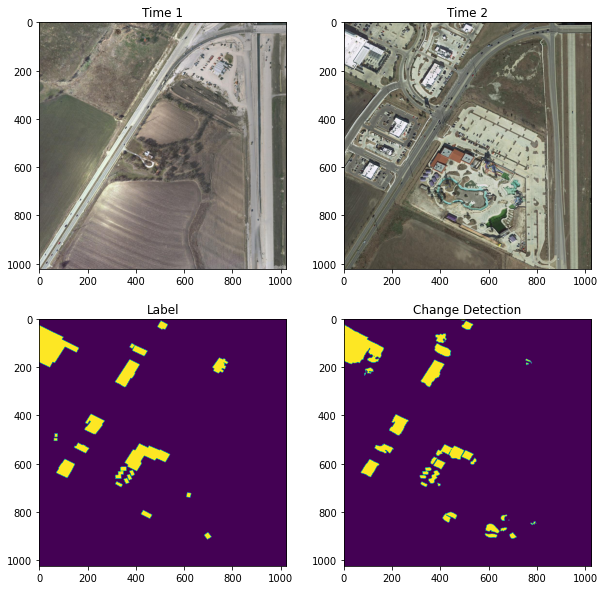

In [3]:
# 模型检测
import paddle
from paddleseg.models import UNetPlusPlus,UNet3Plus
import matplotlib.pyplot as plt


model_path = 'output_2_3_E100_L/best_model/model.pdparams'  # 加载得到的最好参数
model = UNetPlusPlus(in_channels=6, num_classes=2, use_deconv=True)
# model = UNet3Plus(in_channels=6, num_classes=2)
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)


for idx, (img, lab) in enumerate(val_data):  # 从test_data来读取数据

    if idx == 6: 
    
        m_img = img.reshape((1, 6, 1024, 1024))
        m_pre = model(m_img)
        s_img = img.reshape((6, 1024, 1024)).numpy().transpose(1, 2, 0)
        # 拆分6通道为两个3通道的不同时段图像
        s_A_img = s_img[:,:,0:3]
        s_B_img = s_img[:,:,3:6]
        lab_img = lab.reshape((1024, 1024)).numpy()
        pre_img = paddle.argmax(m_pre[0], axis=1).reshape((1024, 1024)).numpy()
        plt.figure(figsize=(10, 10))
        plt.subplot(2,2,1);plt.imshow(s_A_img.astype('int64'));plt.title('Time 1')
        plt.subplot(2,2,2);plt.imshow(s_B_img.astype('int64'));plt.title('Time 2')
        plt.subplot(2,2,3);plt.imshow(lab_img);plt.title('Label')
        plt.subplot(2,2,4);plt.imshow(pre_img);plt.title('Change Detection')
        plt.show()
        break  

In [12]:
# 多种指标

In [5]:
import os
import paddle
import numpy as np
from paddleseg.models import UNetPlusPlus  # or UNet3Plus
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# 设置路径
model_path = 'output_2_3_E100_L/best_model/model.pdparams'
model = UNetPlusPlus(in_channels=6, num_classes=2, use_deconv=True)
model.set_dict(paddle.load(model_path))
model.eval()

# 初始化混淆矩阵
num_classes = 2
conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)

        
for idx, (img, lab) in enumerate(val_data):
    img_tensor = img.reshape((1, 6, 1024, 1024))
    with paddle.no_grad():
        pred = model(img_tensor)
        pred_label = paddle.argmax(pred[0], axis=1).reshape((1024, 1024)).numpy()

    label_np = lab.reshape((1024, 1024)).numpy()

    # 更新混淆矩阵
    conf_mat += confusion_matrix(label_np.flatten(), pred_label.flatten(), labels=list(range(num_classes)))

# 计算各类指标
TP = np.diag(conf_mat)
FP = conf_mat.sum(axis=0) - TP
FN = conf_mat.sum(axis=1) - TP
TN = conf_mat.sum() - (TP + FP + FN)

IoU = TP / (TP + FP + FN + 1e-10)
Recall = TP / (TP + FN + 1e-10)
Precision = TP / (TP + FP + 1e-10)
F1 = 2 * Precision * Recall / (Precision + Recall + 1e-10)

mIoU = np.mean(IoU)
PA = TP.sum() / conf_mat.sum()

# 打印
print(f"👉 Confusion Matrix:\n{conf_mat}")
print(f"✅ Pixel Accuracy (PA): {PA:.4f}")
print(f"✅ Mean IoU (mIoU): {mIoU:.4f}")
print(f"✅ Per-class IoU: {IoU}")
print(f"✅ Per-class Recall: {Recall}")
print(f"✅ Per-class Precision: {Precision}")
print(f"✅ Per-class F1 Score: {F1}")


👉 Confusion Matrix:
[[25469642  6325761]
 [ 1506507   252522]]
✅ Pixel Accuracy (PA): 0.7666
✅ Mean IoU (mIoU): 0.3980
✅ Per-class IoU: [0.76481025 0.03123421]
✅ Per-class Recall: [0.80104794 0.14355761]
✅ Per-class Precision: [0.94415411 0.03838722]
✅ Per-class F1 Score: [0.86673369 0.06057636]
